### Продакт-менеджер Василий попросил вас проанализировать завершенные уроки и ответить на следующие вопросы:

1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене).


2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*. (<font size="2"> *завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен</font>)


3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом). 


4. Выяви самые популярные курсы (ТОП-3) по количеству регистраций на них. А также курсы с самым большим оттоком (ТОП-3). 


5. Напиши функцию на python, позволяющую строить когортный (семестровый) анализ. В период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов. 


6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики: R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 0.1 до 0.5, monetary от 55 до 72 баллов.

### Изучение данных

In [194]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [195]:
sns.set_theme(style="darkgrid")

In [196]:
df_assessements = pd.read_csv('assessments.csv')
df_courses = pd.read_csv('courses.csv')
df_student_assessement = pd.read_csv('studentAssessment.csv')
df_student_registration = pd.read_csv('studentRegistration.csv')

In [197]:
print(df_assessements.head(), '\n')
print(df_assessements.shape)
print(df_assessements.assessment_type.unique())

  code_module code_presentation  id_assessment assessment_type   date  weight
0         AAA             2013J           1752             TMA   19.0    10.0
1         AAA             2013J           1753             TMA   54.0    20.0
2         AAA             2013J           1754             TMA  117.0    20.0
3         AAA             2013J           1755             TMA  166.0    20.0
4         AAA             2013J           1756             TMA  215.0    30.0 

(206, 6)
['TMA' 'Exam' 'CMA']


#### Описание столбцов:

- *code_module* — идентификационный код предмета.

- *code_presentation* — семестр (Идентификационный код).

- *id_assessment* — тест (Идентификационный номер ассессмента).

- *assessment_type* — тип теста. Существуют три типа оценивания: оценка преподавателя (TMA), компьютерная оценка (СМА), экзамен по курсу (Exam).

- *date* — информация об окончательной дате сдачи теста. Рассчитывается как количество дней с момента начала семестра. Дата начала семестра имеет номер 0 (ноль).

- *weight* — вес теста в % в оценке за курс. Обычно экзамены рассматриваются отдельно и имеют вес 100%; сумма всех остальных оценок составляет 100%.

In [198]:
df_assessements.isna().sum()

code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64

In [199]:
df_assessements[df_assessements.duplicated()] # дубликатов нет

,code_module,code_presentation,id_assessment,assessment_type,date,weight


Имеются пропуски в столбце <u>date</u>, однако мы не будем убирать данные строки - они могут понадобиться при дальнейшей работе.

---

In [200]:
print(df_courses.head(), '\n')
print(df_courses.shape)

  code_module code_presentation  module_presentation_length
0         AAA             2013J                         268
1         AAA             2014J                         269
2         BBB             2013J                         268
3         BBB             2014J                         262
4         BBB             2013B                         240 

(22, 3)


#### Описание столбцов:

- *code_module* — предмет (идентификационный код).

- *code_presentation* — семестр (идентификационный код).

- *module_presentation_length* — продолжительность семестра в днях.

In [201]:
df_courses.isna().sum() # пропусков нет

code_module                   0
code_presentation             0
module_presentation_length    0
dtype: int64

In [202]:
df_courses[df_courses.duplicated()] # дубликатов нет

,code_module,code_presentation,module_presentation_length


---

In [203]:
print(df_student_assessement.head(), '\n')
print(df_student_assessement.shape)

   id_assessment  id_student  date_submitted  is_banked  score
0           1752       11391              18          0   78.0
1           1752       28400              22          0   70.0
2           1752       31604              17          0   72.0
3           1752       32885              26          0   69.0
4           1752       38053              19          0   79.0 

(173912, 5)


#### Описание столбцов:

- *id_assessment* — тест (идентификационный номер).

- *id_student* — идентификационный номер студента.

- *date_submitted* — дата сдачи теста студентом, измеряемая как количество дней с начала семестра.

- *is_banked* — факт перезачета теста с прошлого семестра (иногда курсы перезачитывают студентам, вернувшимся из академического отпуска).

- *score* — оценка учащегося в этом тесте. Диапазон составляет от 0 до 100. Оценка ниже 40 неудачная/неуспешная сдача теста.

In [204]:
df_student_assessement.isna().sum()

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

In [205]:
df_student_assessement[df_student_assessement.duplicated()] # дубликатов нет

,id_assessment,id_student,date_submitted,is_banked,score


Имеются NaN'ы в столбце <u>score</u>, но опять-таки лучше их оставить и отфильтровать при необходимости позже.

---

In [206]:
df_student_registration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


#### Описание столбцов:

- *code_module* — предмет (идентификационный код).

- *code_presentation* — семестр (идентификационный код)

- *id_student* — идентификационный номер студента.

- *date_registration* — дата регистрации студента. Это количество дней, измеренное от начала семестра (например, отрицательное значение -30 означает, что студент зарегистрировался на прохождение курса за 30 дней до его начала).

- *date_unregistration* — дата отмены регистрации студента с предмета. У студентов, окончивших курс, это поле остается пустым.

In [207]:
print(df_student_registration.shape)
print(df_student_registration.isna().sum())

(32593, 5)
code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64


In [208]:
df_student_registration[df_student_registration.duplicated()] # дубликатов нет

,code_module,code_presentation,id_student,date_registration,date_unregistration


В наличие пропусков в <u>date_unregistration</u> нет ничего удивительного - эти люди закончили курс. А вот отстутствие даты регистрации заставляет насторожиться - этих студентов нельзя будет учитывать, если надо будет работать с регистрацией.

---
---
---

#### 1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене).

Сначала оставим только тех, кто вообще сдавал экзамен, и объединим получившиеся данные с таблицой по результатам.

In [209]:
df_exams = df_assessements[df_assessements.assessment_type == 'Exam']

df_score_subject = df_student_assessement \
    .merge(df_exams, on='id_assessment') 

Оставим тех, кто сдал экзамен (балл >= 40) и отберём только уникальных студентов, чтобы не было повторов. Затем фильтруем по условию (только <b>один</b> курс).

In [234]:
df_students_success_exams_is_one = df_score_subject \
    [(df_score_subject.assessment_type == 'Exam') & (df_score_subject.score >= 40)] \
    .groupby('id_student', as_index=False) \
    .agg({'id_assessment': 'count'}) \
    .rename(columns={'id_assessment': 'success_exams'}) \
    .query('success_exams == 1') \
    .id_student.nunique()

In [235]:
df_students_success_exams_is_one

3802

---

#### 2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*. 
##### * *завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен*

Создадим два датасета: 

1) где будем считать общее кол-во студентов по курсам и экзаменам;

2) и кол-во студентов, успешной сдавших экзамен;

In [212]:
df_exams_all_results = df_score_subject \
    .groupby(['code_module', 'id_assessment'], as_index=False) \
    .agg({'id_student': 'count'}) \
    .rename(columns={'id_student': 'student_count'})

df_exams_good_results = df_score_subject \
    .query('score >= 40') \
    .groupby(['code_module', 'id_assessment'], as_index=False) \
    .agg({'id_student': 'count'}) \
    .rename(columns={'id_student': 'student_count'})

Объединим таблицы и добавим колонку с завершаемостью по формуле выше.
Затем отсортируем по завершаемости сверху вниз.

In [213]:
df_good_to_all = df_exams_good_results.merge(df_exams_all_results, on=['code_module','id_assessment']) 
df_good_to_all['completeness'] = df_good_to_all['student_count_x'] / df_good_to_all['student_count_y']
df_good_to_all['completeness'] = df_good_to_all['completeness'].mul(100).round(1)
df_good_to_all.sort_values('completeness', ascending=False)

,code_module,id_assessment,student_count_x,student_count_y,completeness
4,DDD,25361,485,524,92.6
3,DDD,25354,878,968,90.7
0,CCC,24290,664,747,88.9
5,DDD,25368,842,950,88.6
1,CCC,24299,1019,1168,87.2
2,DDD,25340,504,602,83.7


Визуализируем данные для большей наглядности, определив нижнюю границу оси ординат в 80% и отсортировав в порядке убывания.

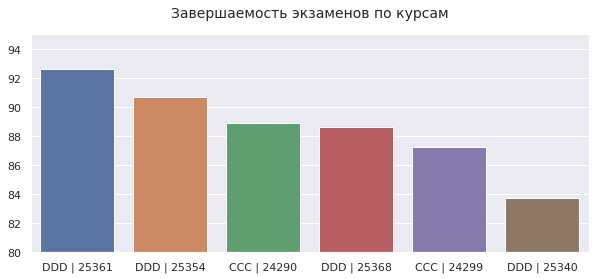

In [239]:
df_good_to_all['code_and_assessment'] = df_good_to_all['code_module'] + ' | ' + df_good_to_all['id_assessment'].astype(str)


plt.figure(figsize=(10,4))
ax = sns.barplot(x='code_and_assessment', y='completeness', data=df_good_to_all, \
                order=df_good_to_all.sort_values('completeness', ascending=False).code_and_assessment);
ax.set(xlabel=None);
ax.set(ylabel=None);
plt.title('Завершаемость экзаменов по курсам', fontsize=14, y=1.05);
plt.ylim(80, 95);

---

#### 3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом).

Фильтруем по условию, группируем по предмету и считаем среднее.

In [240]:
avg_date_exam = df_score_subject.query('score >= 40') \
    .groupby('code_module', as_index=False) \
    .agg({'date_submitted': 'mean'})

---

#### 4. Выяви самые популярные курсы (ТОП-3) по количеству регистраций на них. А также курсы с самым большим оттоком (ТОП-3). 

Берем <u>code_module</u> курса, считаем кол-во уникальных студентов (так как могли записываться по нескольку раз на один курс), сортируем и оставляем топ-3. 

Для расчёта оттока нужно предварительно вычесть количество дублирующихся студентов, так как они снова пришли на курс и это не может считать оттоком.

* *nunique по дефолту не учитывает NaN'ы*

In [241]:
top_3_courses_registration = df_student_registration.groupby('code_module', as_index=False) \
    .agg({'id_student': 'nunique', 'date_registration': 'count'}) \
    .rename(columns={'id_student': 'unique_registrations', 'date_registration' : 'all_registrations'}) \
    .sort_values('unique_registrations', ascending=False) 

top_3_courses_registration['double_reg'] = top_3_courses_registration['all_registrations'] - \
                                    top_3_courses_registration['unique_registrations']



top_3_courses_unregistration = df_student_registration.groupby('code_module', as_index=False) \
    .agg({'date_unregistration': 'count'}) \
    .rename(columns={'date_unregistration': 'students_unregistered'}) \
    .sort_values('students_unregistered', ascending=False) \


reg_unreg_merge = top_3_courses_unregistration.merge(top_3_courses_registration, on='code_module')
reg_unreg_merge['true_unregistrations'] = reg_unreg_merge.students_unregistered - reg_unreg_merge.double_reg


top_3_courses_unregistration = reg_unreg_merge[['code_module', 'true_unregistrations']] \
                                .sort_values('true_unregistrations', ascending=False)
top_3_courses_registration = top_3_courses_registration[['code_module', 'unique_registrations']]

In [242]:
top_3_courses_registration.head(3)

,code_module,unique_registrations
1,BBB,7692
5,FFF,7397
3,DDD,5848


In [243]:
top_3_courses_unregistration.head(3)

,code_module,true_unregistrations
1,BBB,2169
0,FFF,2026
2,DDD,1826


Визуализация соотношения притока к оттоку:

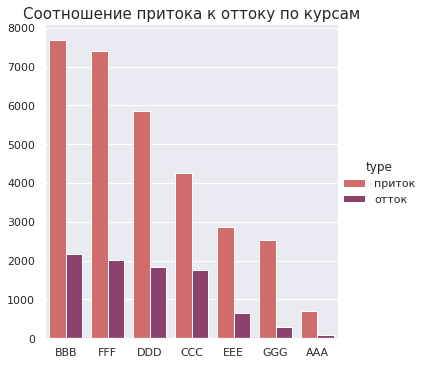

In [244]:
top_3_courses_registration['type'] = 'приток'
top_3_courses_unregistration = top_3_courses_unregistration.rename(columns={'true_unregistrations': 'number'})
top_3_courses_unregistration['type'] = 'отток'
top_3_courses_registration = top_3_courses_registration.rename(columns={'unique_registrations': 'number'})


data = [top_3_courses_registration, top_3_courses_unregistration]
pritok_ottok = pd.concat(data)


ax = sns.catplot(x ='code_module', y ='number',
               hue = 'type', kind='bar', data = pritok_ottok, palette = "flare");
ax.set(xlabel=None);
ax.set(ylabel=None);
plt.title('Cоотношение притока к оттоку по курсам', fontsize=15, y=1.1);

---

#### 5.Напиши функцию на python, позволяющую строить когортный (семестровый) анализ. В период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов. (10 баллов) 

<b>Пример</b>: пользователь пришел на сайт из контекстной рекламы 17 июля и купил окно. Его можно включить сразу в три группы:

- <u>Пользователи, пришедшие с контекстной рекламы</u>. Помогает определить эффективность контекста по сравнению с другими каналами привлечения покупателей.
- <u>Клиенты, купившие окно в июле</u>. Позволяет определить сезонность продаж.
- <u>Покупатели товара «окно»</u>. Помогает в определении спроса на конкретный товар у разных групп целевой аудитории.

<b>Теоретические положения когортного анализа</b>:
    
    
- *Суть когортного анализа* — объединение клиентов (пользователей, посетителей) в группы по одинаковым характеристикам или атрибутам и отслеживание их поведения во времени;

- *Признак формирования когорты* — действие, которое объединяет людей в группу: первый визит, покупка, установка, регистрация и т.п.

-  *Размер когорты* — временной интервал: день, неделя, месяц;

- *Отчетный период* — время исследования поведения групп;

- *Анализируемый ключевой показатель*: ROI, Retention Rate, LTV и т.д.


Когорта отличается от сегмента именно временным признаком.

<b>В контексте задачи</b>:

- *Признак когорты* - студенты;
- *Размер* - семестр в период с 2013 по 2014 год;
- *Анализируемые показатели*  - завершаемость и сроки сдачи курсов.

Сначала рассчитаем завершаемость по семестрам. 

В первой переменной считаем количество сдавших экзамены, во второй - общее число попыток. Затем делим одно на другое, приводим в удобочитаемый вид, и получаем завершамость.

В каждом случае нам нужно сначала объединить 2 таблицы, так как результаты тестирования находятся в отдельной таблице. В конечной таблице лучше оставить только интересующие нас колонки, чтобы это легче читалось.

In [220]:
exams_success = df_assessements.merge(df_student_assessement, on=['id_assessment']) \
                .query('assessment_type == "Exam" & score >= 40') \
                .groupby('code_presentation', as_index=False) \
                .agg({'score': 'count'}) \
                .rename(columns={'score': 'success'})


exams_all = df_assessements.merge(df_student_assessement, on=['id_assessment']) \
                .query('assessment_type == "Exam"') \
                .groupby('code_presentation', as_index=False) \
                .agg({'score': 'count'}) \
                .rename(columns={'score': 'all'})


success_to_all = exams_success.merge(exams_all, on='code_presentation')
success_to_all['completeness'] = round(success_to_all['success'] / success_to_all['all'], 2).mul(100) \
                                            .astype(int)


completeness = success_to_all[['code_presentation', 'completeness']] \
                                    .sort_values('completeness')
completeness

,code_presentation,completeness
0,2013B,84
3,2014J,88
2,2014B,90
1,2013J,91


Считаем среднее время сдачи. Не забываем, что нас <u>интересуют успешные сдачи экзаменов</u>.

In [221]:
df_big = df_student_assessement.merge(df_assessements, on='id_assessment')


avg_submission = df_big.query('assessment_type == "Exam" and score >= 40 ') \
    .groupby(['code_presentation'], as_index=False) \
    .agg({'date_submitted': 'mean'}).round(0) \
    .rename(columns={'date_submitted':'avg_submission'}) \
    .sort_values('avg_submission', ascending=False) \
    .head()

avg_submission['avg_submission'] = avg_submission['avg_submission'].astype(int)
avg_submission

,code_presentation,avg_submission
3,2014J,244
1,2013J,240
2,2014B,233
0,2013B,230


Остлось только объединить получившиеся таблицы:

In [222]:
worst_semester = completeness.merge(avg_submission, on='code_presentation')
worst_semester

,code_presentation,completeness,avg_submission
0,2013B,84,230
1,2014J,88,244
2,2014B,90,233
3,2013J,91,240


Можно также реализовать код выше в виде функции. Переданный аргумент - первая таблица, которую мы объединяем (в данном случае - *df_assessments*).

In [245]:
def worst_semesters(df):
    
    exams_success = df.merge(df_student_assessement, on=['id_assessment']) \
                .query('assessment_type == "Exam" & score >= 40') \
                .groupby('code_presentation', as_index=False) \
                .agg({'score': 'count'}) \
                .rename(columns={'score': 'success'})


    exams_all = df.merge(df_student_assessement, on=['id_assessment']) \
                .query('assessment_type == "Exam"') \
                .groupby('code_presentation', as_index=False) \
                .agg({'score': 'count'}) \
                .rename(columns={'score': 'all'})


    success_to_all = exams_success.merge(exams_all, on='code_presentation')
    success_to_all['completeness'] = round(success_to_all['success'] / success_to_all['all'], 2) \
                                    .mul(100).astype(int)


    completeness = success_to_all[['code_presentation', 'completeness']] \
                                    .sort_values('completeness')
    
    
    df_big = df_student_assessement.merge(df_assessements, on='id_assessment')


    avg_submission = df_big.query('assessment_type == "Exam" and score >= 40 ') \
    .groupby(['code_presentation'], as_index=False) \
    .agg({'date_submitted': 'mean'}).round(0) \
    .rename(columns={'date_submitted':'avg_submission'}) \
    .sort_values('avg_submission', ascending=False) \
    .head()

    avg_submission['avg_submission'] = avg_submission['avg_submission'].astype(int)
    
    worst_semester = completeness.merge(avg_submission, on='code_presentation')
    
    return worst_semester

In [246]:
worst_semesters(df_assessements)

,code_presentation,completeness,avg_submission
0,2013B,84,230
1,2014J,88,244
2,2014B,90,233
3,2013J,91,240


---

#### 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики: 
- R - среднее время сдачи одного экзамена, 
- F - завершаемость курсов, 
- M - среднее количество баллов, получаемое за экзамен. 

#### Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 0.1 до 0.5, monetary от 55 до 72 баллов.

---
Внутри каждого кластера будет 3 группы, где 1 - "хороший" показатель (например, высокий средний балл), 2 - "средний" и 3 - "плохой". В качестве границ возьмём следующие значения:

- нижняя граница - среднее минус стандартное отклонение; 
- верхняя граница - среднее плюс стандартное отклонение; 
- средняя граница - всё, что между.

---
Сначала находим необходимые метрики в привязки к студентам.

Завершаемость курсов для студента =
*кол-во законченных курсов / кол-во начатых курсов*. 

Если курс окончен, то date_ungeristration = NaN, поэтому нам небходимо сделать <u>обратную</u> операцию:

*1 - кол-во <b>НЕ</b>законченных курсов / кол-во начатых курсов*

In [247]:
df_exam = df_big.query('assessment_type == "Exam"')


df_avg_date = df_exam.groupby(['id_student'], as_index=False) \
    .agg({'date_submitted':'mean'}) \
    .rename(columns={'date_submitted': 'avg_date'})


df_avg_score = df_exam.groupby(['id_student'], as_index=False) \
    .agg({'score':'mean'}) \
    .rename(columns={'score': 'avg_score'})


df_completeness = df_exam.merge(df_student_registration, on='id_student').groupby('id_student', as_index=False) \
                        .agg({'date_registration': 'count', 'date_unregistration': 'count'}) \


df_completeness['completeness'] = np.where(df_completeness['date_unregistration'] == 0, 100, \
        (1 - df_completeness['date_unregistration'] / df_completeness['date_registration']) * 100)

Объединим все таблицы в одну по *id_student*.

In [248]:
df_rfm = df_avg_date.merge(df_avg_score, on='id_student').merge(df_completeness, on='id_student')
df_rfm = df_rfm[['id_student', 'avg_date', 'completeness', 'avg_score']]
df_rfm.head()

,id_student,avg_date,completeness,avg_score
0,23698,243.0,100.0,80.0
1,24213,236.0,50.0,58.0
2,27116,243.0,100.0,96.0
3,28046,237.0,100.0,40.0
4,28787,243.0,100.0,44.0


Взглянем на получившиеся данные с точки зрения описательной статистики.

In [250]:
df_rfm.describe()

,id_student,avg_date,completeness,avg_score
count,4.633000e+03,4633.000000,4633.000000,4633.000000
mean,7.256904e+05,238.462227,95.954745,65.117958
std,5.753498e+05,5.653378,13.790635,20.470561
min,2.369800e+04,229.000000,0.000000,0.000000
25%,5.011580e+05,234.000000,100.000000,50.000000
50%,5.884820e+05,241.000000,100.000000,66.000000
75%,6.463510e+05,243.000000,100.000000,82.000000
max,2.698251e+06,285.000000,100.000000,100.000000


Видим, что в <u>completeness</u> (q=0.25) = (q=0.5) = (q=0.75). Также странно, что минимальное значение <u>avg_score</u> = 0.

Взглянем на распределение завершаемости и на колонки с нулями:

In [251]:
df_rfm.completeness.value_counts()

100.000000    4255
50.000000      304
66.666667       45
33.333333       25
0.000000         3
25.000000        1
Name: completeness, dtype: int64

В данных есть 3 строки без оценки - уберём их.

Стопроцентная завершаемость действительно преобладает, но интересно также то, что имеется всего 6 значений, в связи с чем определение границ интервалов должно быть другим. Исходя из своего студенческого опыта, предлагаю следующую градацию:

- <b>3</b> = 0%, 25%, 33%
- <b>2</b> = 50%, 66%
- <b>1</b> = 100%

In [252]:
df_rfm.query('avg_score == 0')

,id_student,avg_date,completeness,avg_score
75,81351,248.0,100.0,0.0
137,131152,244.0,100.0,0.0
1736,556660,235.0,100.0,0.0


In [253]:
date_lower_bound = df_rfm.avg_date.mean() - df_rfm.avg_date.std()
date_upper_bound = df_rfm.avg_date.mean() + df_rfm.avg_date.std()

score_lower_bound = df_rfm.avg_score.mean() - df_rfm.avg_score.std()
score_upper_bound = df_rfm.avg_score.mean() + df_rfm.avg_score.std()

Создаём колонки и заполняем их по условиям. 

In [254]:
df_rfm['R'] = np.where(
    df_rfm['avg_date'] < date_lower_bound, 1, np.where(
    df_rfm['avg_date'] > date_upper_bound, 3, 2)) 


df_rfm['completeness'] = round(df_rfm['completeness'], 0)
df_rfm['F'] = np.where(
    (df_rfm['completeness'] == 0) | (df_rfm['completeness'] == 25) | (df_rfm['completeness'] == 33), 3,
    np.where((df_rfm['completeness'] == 50) | (df_rfm['completeness'] == 66), 2, 1)) 


df_rfm['M'] = np.where(
    df_rfm['avg_score'] > score_upper_bound, 1, np.where(
    df_rfm['avg_score'] < score_lower_bound, 3, 2)) 

In [255]:
df_rfm.head()

,id_student,avg_date,completeness,avg_score,R,F,M
0,23698,243.0,100.0,80.0,2,1,2
1,24213,236.0,50.0,58.0,2,2,2
2,27116,243.0,100.0,96.0,2,1,1
3,28046,237.0,100.0,40.0,2,1,3
4,28787,243.0,100.0,44.0,2,1,3


Построим распределение значений метрик, чтобы увидеть, какие из значений преобладают и сделать выводы.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


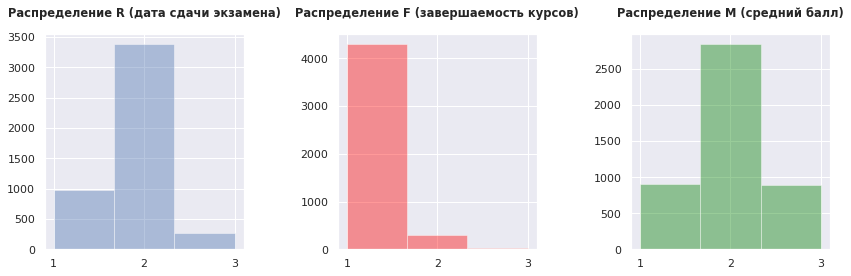

In [233]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

sns.distplot(df_rfm.R, bins=3, kde=False, ax=ax1);
ax1.set_xticks(range(1, 4))
ax1.set_xticklabels([1, 2, 3])
ax1.set(xlabel=None)
ax1.set_title('Распределение R (дата сдачи экзамена)', fontsize=11.5, y=1.05, weight='bold');

sns.distplot(df_rfm.F, bins=3, kde=False, ax=ax2, color='red');
ax2.set_xticks(range(1, 4))
ax2.set_xticklabels([1, 2, 3])
ax2.set(xlabel=None)
ax2.set_title('Распределение F (завершаемость курсов)', fontsize=11.5, y=1.05, weight='bold');

sns.distplot(df_rfm.M, bins=3, kde=False, ax=ax3, color='green');
ax3.set_xticks(range(1, 4))
ax3.set_xticklabels([1, 2, 3])
ax3.set(xlabel=None)
ax3.set_title('Распределение M (средний балл)', fontsize=11.5, y=1.05, weight='bold');


plt.tight_layout()

- Начатые курсы завершает подавляющее большинство студентов. 
- Почти все сдают экзамен вовремя или раньше среднего, но есть совсем небольшая часть тех, кто делает это в последний момент. 
- Низкий средний балл встречается почти так же часто, как и высокий (около 20%) - на это стоит обратить внимание преподавателям и составителям учебных программ.